In [14]:
import re
import pandas as pd

class ProteinTimeParser:
    def __init__(self, log_file, method):
        self.log_file = log_file
        self.method = method
        self.parsed_data = []

    def parse(self):
        """Parses the log file and extracts only 'INFO' log entries for proteins and their execution times."""
        with open(self.log_file, 'r') as file:
            for line in file:
                parsed_entry = self._parse_line(line.strip())
                if parsed_entry:
                    self.parsed_data.append(parsed_entry)

    def _parse_line(self, line):
        """Parses a single log line and extracts protein name and time taken."""
        if self.method == 'diffdock':
            info_pattern = re.compile(
                r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) - INFO - '
                r'(?P<protein_id>\S+) took (?P<exec_time>\d+\.\d+) seconds'
            )
        elif self.method in ('gnina', 'vina'):
            info_pattern = re.compile(
                r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \[INFO\] '
                r'(?P<protein_id>\S+),(?P<exec_time>\d+\.\d+)'
            )
        else:
            raise ValueError(f"Unsupported method: {self.method}")

        match = info_pattern.match(line)
        if match:
            return match.groupdict()
        return None

    def to_dataframe(self):
        """Converts extracted protein execution times into a Pandas DataFrame."""
        df = pd.DataFrame(self.parsed_data)
        df["exec_time"] = df["exec_time"].astype(float)  # Convert time to float
        return df


In [12]:
import os 
os.getcwd()

'/Users/aoxu/projects/DrugDiscovery/PoseBench/notebooks'

In [20]:
for method in ['diffdock', 'gnina', 'vina']:
    log_file = f"../analysis/{method}_timing.log"  # Replace with the actual log file path
    parser = ProteinTimeParser(log_file, method)
    parser.parse()
    df = parser.to_dataframe()
    print(f"Method: {method}")
    print(df.describe())

Method: diffdock
        exec_time
count  259.000000
mean    48.478726
std     16.387655
min     14.340000
25%     37.500000
50%     45.670000
75%     58.590000
max     97.060000
Method: gnina
         exec_time
count  1284.000000
mean      6.203466
std       6.786108
min       0.250000
25%       3.070000
50%       4.510000
75%       6.790000
max      93.740000
Method: vina
        exec_time
count  428.000000
mean     6.128668
std      9.268926
min      0.250000
25%      1.390000
50%      3.055000
75%      6.315000
max     93.740000


In [18]:
log_file = "../analysis/gnina_timing.log"  # Replace with the actual log file path
parser = ProteinTimeParser(log_file, 'gnina')
parser.parse()
df = parser.to_dataframe()
df 

,timestamp,protein_id,exec_time
0,"2025-02-03 08:28:31,214",7ZZW_KKW,6.26
1,"2025-02-03 08:28:31,214",7ZZW_KKW,6.26
2,"2025-02-03 08:28:52,382",7MAE_XUS,21.17
3,"2025-02-03 08:28:52,382",7MAE_XUS,21.17
4,"2025-02-03 08:29:00,173",7MEU_MGP,7.79
...,...,...,...
1279,"2025-02-03 09:55:51,920",7JHQ_VAJ,1.76
1280,"2025-02-03 09:56:04,717",8FO5_Y4U,12.80
1281,"2025-02-03 09:56:06,828",8CSD_C5P,2.11
1282,"2025-02-03 09:56:20,329",8EX2_Q2Q,13.50


In [21]:
log_file = "../analysis/vina_timing.log"  # Replace with the actual log file path
parser = ProteinTimeParser(log_file, 'vina')
parser.parse()
df = parser.to_dataframe()
df 

,timestamp,protein_id,exec_time
0,"2025-02-03 09:13:00,731",7ZZW_KKW,4.13
1,"2025-02-03 09:13:03,896",7MAE_XUS,3.16
2,"2025-02-03 09:13:15,365",7MEU_MGP,11.47
3,"2025-02-03 09:13:15,764",7A9E_R4W,0.40
4,"2025-02-03 09:13:17,533",7SFO_98L,1.77
...,...,...,...
423,"2025-02-03 09:55:51,920",7JHQ_VAJ,1.76
424,"2025-02-03 09:56:04,717",8FO5_Y4U,12.80
425,"2025-02-03 09:56:06,828",8CSD_C5P,2.11
426,"2025-02-03 09:56:20,329",8EX2_Q2Q,13.50


### timing analysis for boltz-2 

In [1]:
# Parse Boltz runtime log and compute average time per system
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def parse_boltz_timing_log(log_file):
    """Parse Boltz runtime log and extract system names and execution times."""
    timing_data = []
    
    # Pattern to match Boltz log entries
    # Example: "2025-06-13 23:23:04,938 | INFO | SUCCESS 8pw1__10__1.J__1.T.yaml in 62.24s"
    pattern = re.compile(
        r'(?P<timestamp>\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2},\d{3}) \| INFO \| '
        r'SUCCESS (?P<system_file>.*?)\.yaml in (?P<exec_time>\d+\.\d+)s'
    )
    
    with open(log_file, 'r') as file:
        for line in file:
            match = pattern.match(line.strip())
            if match:
                system_name = match.group('system_file')
                exec_time = float(match.group('exec_time'))
                timestamp = match.group('timestamp')
                
                timing_data.append({
                    'system_name': system_name,
                    'exec_time': exec_time,
                    'timestamp': timestamp
                })
    
    return pd.DataFrame(timing_data)

# Parse the Boltz timing log
boltz_log_file = "../../forks/boltz/logs/plinder_set_0_runtime.log"
boltz_df = parse_boltz_timing_log(boltz_log_file)

print(f"Total systems processed: {len(boltz_df)}")
print(f"Boltz Timing Statistics:")
print(boltz_df['exec_time'].describe())

# Display first few entries
print(f"\nFirst 10 systems:")
print(boltz_df.head(10))

# Compute average time per unique system (if there are duplicates)
system_avg_times = boltz_df.groupby('system_name')['exec_time'].agg(['mean', 'count', 'std']).reset_index()
system_avg_times.columns = ['system_name', 'avg_time', 'run_count', 'std_time']

print(f"\nSystems with multiple runs: {len(system_avg_times[system_avg_times['run_count'] > 1])}")
print(f"\nAverage execution time per system:")
print(system_avg_times.describe())

Total systems processed: 2064
Boltz Timing Statistics:
count    2064.000000
mean       63.597679
std        84.279784
min         2.720000
25%         2.840000
50%         2.920000
75%       108.622500
max       581.080000
Name: exec_time, dtype: float64

First 10 systems:
                         system_name  exec_time                timestamp
0                 8pw1__10__1.J__1.T      62.24  2025-06-13 23:23:04,938
1                  5oju__1__2.B__2.K      91.27  2025-06-13 23:24:36,206
2          4x8d__2__1.B__1.T_1.U_1.V      91.80  2025-06-13 23:26:08,006
3  6dft__2__1.E_1.F_1.G_1.H__1.T_1.U     150.58  2025-06-13 23:28:38,585
4                  5eq9__1__1.A__1.E     146.69  2025-06-13 23:31:05,276
5              7erb__2__1.C__1.L_1.M      64.66  2025-06-13 23:32:09,933
6              3rou__1__1.A_1.B__1.D      63.01  2025-06-13 23:33:12,938
7              1z2i__1__1.A_1.B__1.E     167.70  2025-06-13 23:36:00,636
8                  3w6c__1__1.A__1.E     133.01  2025-06-13 23:38:13,

In [4]:
boltz_df['system_name'].nunique(), boltz_df['system_name'].value_counts().head(10)

(1032,
 8one__1__1.A__1.F_1.K                2
 8pw1__10__1.J__1.T                   2
 5oju__1__2.B__2.K                    2
 4x8d__2__1.B__1.T_1.U_1.V            2
 6dft__2__1.E_1.F_1.G_1.H__1.T_1.U    2
 5eq9__1__1.A__1.E                    2
 7erb__2__1.C__1.L_1.M                2
 3rou__1__1.A_1.B__1.D                2
 6x82__2__1.D_1.E_1.F__1.H            2
 7tfp__2__1.B_2.C__2.F_2.G            2
 Name: system_name, dtype: int64)

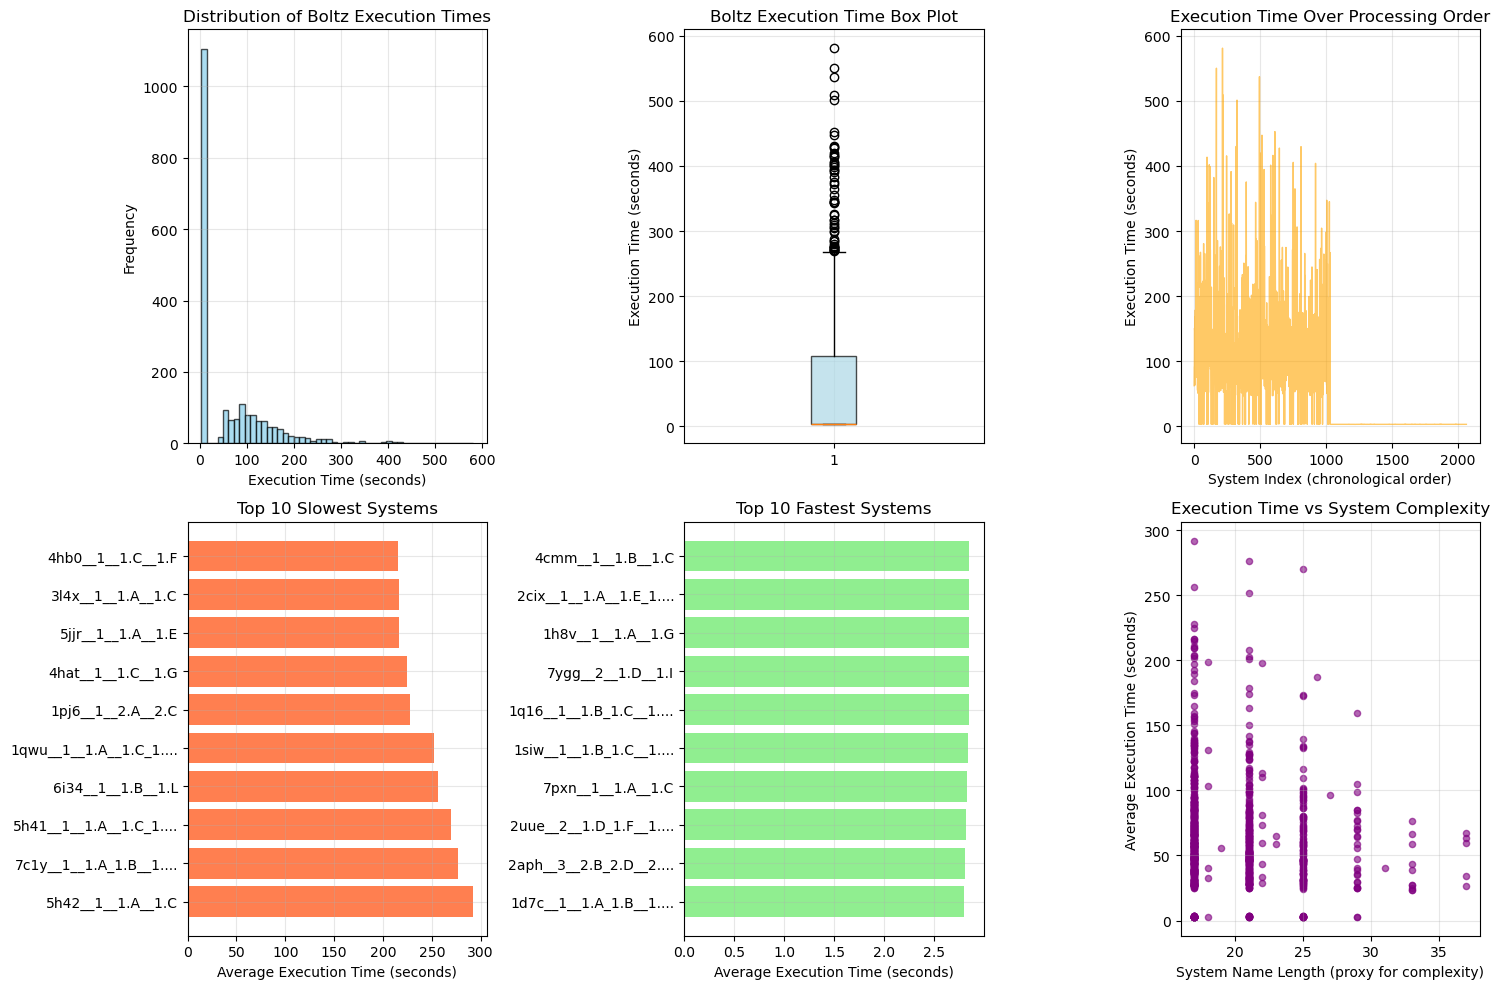


🔍 BOLTZ TIMING ANALYSIS SUMMARY
Total systems processed: 2064
Unique systems: 1032
Average execution time: 63.60 seconds (1.06 minutes)
Median execution time: 2.92 seconds
Fastest system: 2.72 seconds
Slowest system: 581.08 seconds
Standard deviation: 84.28 seconds
Total runtime: 131265.61 seconds (36.46 hours)


In [5]:
# Create visualizations for Boltz timing analysis
plt.figure(figsize=(15, 10))

# 1. Distribution of execution times
plt.subplot(2, 3, 1)
plt.hist(boltz_df['exec_time'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Execution Time (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Boltz Execution Times')
plt.grid(True, alpha=0.3)

# 2. Box plot of execution times
plt.subplot(2, 3, 2)
plt.boxplot(boltz_df['exec_time'], patch_artist=True, 
            boxprops=dict(facecolor='lightblue', alpha=0.7))
plt.ylabel('Execution Time (seconds)')
plt.title('Boltz Execution Time Box Plot')
plt.grid(True, alpha=0.3)

# 3. Execution time over time (chronological)
plt.subplot(2, 3, 3)
boltz_df['timestamp_dt'] = pd.to_datetime(boltz_df['timestamp'])
boltz_df_sorted = boltz_df.sort_values('timestamp_dt')
plt.plot(range(len(boltz_df_sorted)), boltz_df_sorted['exec_time'], 
         alpha=0.6, color='orange', linewidth=1)
plt.xlabel('System Index (chronological order)')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Over Processing Order')
plt.grid(True, alpha=0.3)

# 4. Top 10 slowest systems
plt.subplot(2, 3, 4)
top_slow = system_avg_times.nlargest(10, 'avg_time')
plt.barh(range(len(top_slow)), top_slow['avg_time'], color='coral')
plt.yticks(range(len(top_slow)), [name[:20] + '...' if len(name) > 20 else name 
                                  for name in top_slow['system_name']])
plt.xlabel('Average Execution Time (seconds)')
plt.title('Top 10 Slowest Systems')
plt.grid(True, alpha=0.3)

# 5. Top 10 fastest systems
plt.subplot(2, 3, 5)
top_fast = system_avg_times.nsmallest(10, 'avg_time')
plt.barh(range(len(top_fast)), top_fast['avg_time'], color='lightgreen')
plt.yticks(range(len(top_fast)), [name[:20] + '...' if len(name) > 20 else name 
                                  for name in top_fast['system_name']])
plt.xlabel('Average Execution Time (seconds)')
plt.title('Top 10 Fastest Systems')
plt.grid(True, alpha=0.3)

# 6. Scatter plot: execution time vs system complexity (approximated by name length)
plt.subplot(2, 3, 6)
system_avg_times['name_length'] = system_avg_times['system_name'].str.len()
plt.scatter(system_avg_times['name_length'], system_avg_times['avg_time'], 
           alpha=0.6, color='purple', s=20)
plt.xlabel('System Name Length (proxy for complexity)')
plt.ylabel('Average Execution Time (seconds)')
plt.title('Execution Time vs System Complexity')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"\n🔍 BOLTZ TIMING ANALYSIS SUMMARY")
print(f"=" * 50)
print(f"Total systems processed: {len(boltz_df)}")
print(f"Unique systems: {len(system_avg_times)}")
print(f"Average execution time: {boltz_df['exec_time'].mean():.2f} seconds ({boltz_df['exec_time'].mean()/60:.2f} minutes)")
print(f"Median execution time: {boltz_df['exec_time'].median():.2f} seconds")
print(f"Fastest system: {boltz_df['exec_time'].min():.2f} seconds")
print(f"Slowest system: {boltz_df['exec_time'].max():.2f} seconds")
print(f"Standard deviation: {boltz_df['exec_time'].std():.2f} seconds")
print(f"Total runtime: {boltz_df['exec_time'].sum():.2f} seconds ({boltz_df['exec_time'].sum()/3600:.2f} hours)")

In [7]:
import os
# Compare Boltz timing with other methods
methods_comparison = []

# Add Boltz data
methods_comparison.append({
    'method': 'Boltz',
    'mean_time': boltz_df['exec_time'].mean(),
    'median_time': boltz_df['exec_time'].median(),
    'std_time': boltz_df['exec_time'].std(),
    'min_time': boltz_df['exec_time'].min(),
    'max_time': boltz_df['exec_time'].max(),
    'total_systems': len(boltz_df)
})

# Parse other methods if log files exist
for method in ['diffdock', 'gnina', 'vina']:
    log_file = f"../analysis/{method}_timing.log"
    if os.path.exists(log_file):
        try:
            parser = ProteinTimeParser(log_file, method)
            parser.parse()
            df = parser.to_dataframe()
            
            methods_comparison.append({
                'method': method.title(),
                'mean_time': df['exec_time'].mean(),
                'median_time': df['exec_time'].median(),
                'std_time': df['exec_time'].std(),
                'min_time': df['exec_time'].min(),
                'max_time': df['exec_time'].max(),
                'total_systems': len(df)
            })
        except Exception as e:
            print(f"Could not parse {method}: {e}")

# Create comparison DataFrame
comparison_df = pd.DataFrame(methods_comparison)
print("Method Comparison:")
print(comparison_df.round(2))

# Create comparison visualizations
if len(comparison_df) > 1:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Mean execution time comparison
    axes[0, 0].bar(comparison_df['method'], comparison_df['mean_time'], color=['skyblue', 'orange', 'green', 'red'][:len(comparison_df)])
    axes[0, 0].set_ylabel('Mean Execution Time (seconds)')
    axes[0, 0].set_title('Mean Execution Time by Method')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Median execution time comparison
    axes[0, 1].bar(comparison_df['method'], comparison_df['median_time'], color=['skyblue', 'orange', 'green', 'red'][:len(comparison_df)])
    axes[0, 1].set_ylabel('Median Execution Time (seconds)')
    axes[0, 1].set_title('Median Execution Time by Method')
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # Standard deviation comparison
    axes[1, 0].bar(comparison_df['method'], comparison_df['std_time'], color=['skyblue', 'orange', 'green', 'red'][:len(comparison_df)])
    axes[1, 0].set_ylabel('Standard Deviation (seconds)')
    axes[1, 0].set_title('Execution Time Variability by Method')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Log scale comparison (for methods with very different scales)
    axes[1, 1].bar(comparison_df['method'], comparison_df['mean_time'], color=['skyblue', 'orange', 'green', 'red'][:len(comparison_df)])
    axes[1, 1].set_ylabel('Mean Execution Time (seconds, log scale)')
    axes[1, 1].set_title('Mean Execution Time by Method (Log Scale)')
    axes[1, 1].set_yscale('log')
    axes[1, 1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

# Save results to CSV
boltz_df.to_csv('boltz_timing_analysis.csv', index=False)
system_avg_times.to_csv('boltz_system_average_times.csv', index=False)
comparison_df.to_csv('methods_timing_comparison.csv', index=False)

print(f"\n✅ Analysis complete! Results saved to CSV files:")
print(f"   - boltz_timing_analysis.csv")
print(f"   - boltz_system_average_times.csv") 
print(f"   - methods_timing_comparison.csv")

Method Comparison:
  method  mean_time  median_time  std_time  min_time  max_time  total_systems
0  Boltz       63.6         2.92     84.28      2.72    581.08           2064

✅ Analysis complete! Results saved to CSV files:
   - boltz_timing_analysis.csv
   - boltz_system_average_times.csv
   - methods_timing_comparison.csv
